In [ ]:
import pandas as panda
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the Data

In [ ]:
dataset = panda.read_csv("HateSpeechData.csv")
dataset

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


<Axes: >

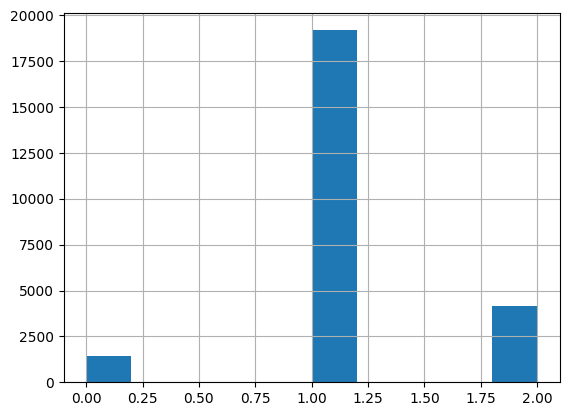

In [ ]:
dataset['class'].hist()

In [ ]:
pip install textstat

In [ ]:
pip install vaderSentiment


In [ ]:
!pip install textstat


In [ ]:
##The above histogram shows that most of the tweets are considered to be offensive words by the CF coders.

In [ ]:
# collecting only the tweets from the csv file into a variable name tweet
tweet=dataset.tweet

## Preprocessing of the tweets

In [ ]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(tweet):

    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')

    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # removal of capitalization
    tweet_lower = punc_remove.str.lower()

    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())

    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])

    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet

    return tweets_p

processed_tweets = preprocess(tweet)

dataset['processed_tweets'] = processed_tweets
dataset

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,processed_tweets
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman complain clean hous amp man alway take t...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat cold tyga dwn bad cuffin dat hoe st place
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cri confus shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranni
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya
...,...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,muthaf lie right tl trash mine bibl scriptur hymn
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",gone broke wrong heart babi drove redneck crazi
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat nigguh like aint fuck...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies,youu got wild bitch tellin lie


## Visualizations

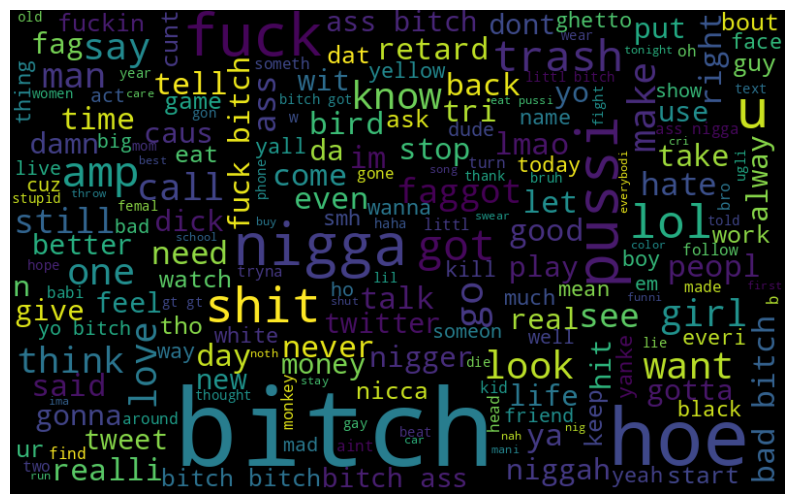

In [ ]:
# visualizing which of the word is most commonly used in the twitter dataset

import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_words = ' '.join([text for text in dataset['processed_tweets'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

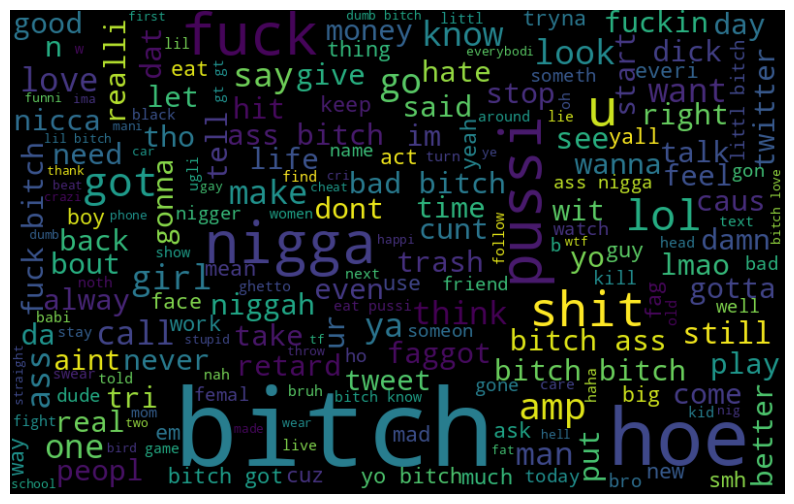

In [ ]:
# visualizing which of the word is most commonly used for hatred speech
hatred_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

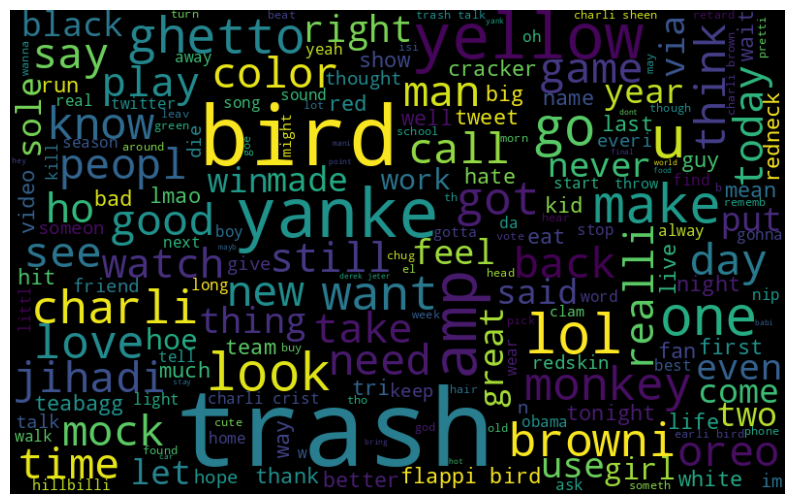

In [ ]:
# visualizing which of the word is most commonly used for offensive speech
offensive_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 2]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(offensive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Feature Generation

In [ ]:
# Bigram Features
bigram_vectorizer = CountVectorizer(ngram_range=(1,2),max_df=0.75, min_df=1, max_features=10000)
# bigram feature matrix
bigram = bigram_vectorizer.fit_transform(processed_tweets).toarray()
bigram

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
#TF-IDF Features

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'] )
tfidf

<24783x6441 sparse matrix of type '<class 'numpy.float64'>'
	with 189618 stored elements in Compressed Sparse Row format>

## Building Models using Logistic Regression

In [ ]:
# Using Bigram Features
X = panda.DataFrame(bigram)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)


model = LogisticRegression(class_weight='balanced',penalty="l2", C=0.01).fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report( y_test, y_preds )
print(report)

print("Accuracy Score:" , accuracy_score(y_test,y_preds))


              precision    recall  f1-score   support

           0       0.32      0.65      0.43       164
           1       0.98      0.81      0.89      1905
           2       0.70      0.95      0.80       410

    accuracy                           0.82      2479
   macro avg       0.66      0.80      0.71      2479
weighted avg       0.89      0.82      0.84      2479

Accuracy Score: 0.8229124647035094


In [ ]:
# Running the model Using TFIDF without additional features

X = tfidf
y = dataset['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)


model = LogisticRegression().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)

print("Accuracy Score:" , accuracy_score(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.61      0.17      0.27       164
           1       0.91      0.97      0.94      1905
           2       0.85      0.84      0.85       410

    accuracy                           0.89      2479
   macro avg       0.79      0.66      0.68      2479
weighted avg       0.88      0.89      0.88      2479

Accuracy Score: 0.8926986688180718


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Sentiment Analysis
sentiment_analyzer = VS()
def count_tags(tweet_c):

    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', tweet_c)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def sentiment_analysis(tweet):
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    twitter_objs = count_tags(tweet)
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitter_objs[0], twitter_objs[1],
                twitter_objs[2]]
    #features = pandas.DataFrame(features)
    return features

def sentiment_analysis_array(tweets):
    features=[]
    for t in tweets:
        features.append(sentiment_analysis(t))
    return np.array(features)

final_features = sentiment_analysis_array(tweet)
#final_features

new_features = panda.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3],
                            'url_tag':final_features[:,4],'mention_tag':final_features[:,5],'hash_tag':final_features[:,6]})
new_features

,Neg,Pos,Neu,Compound,url_tag,mention_tag,hash_tag
0,0.000,0.111,0.889,0.4563,0.0,1.0,0.0
1,0.237,0.000,0.763,-0.6876,0.0,1.0,0.0
2,0.522,0.000,0.478,-0.9550,0.0,2.0,0.0
3,0.000,0.314,0.686,0.5673,0.0,2.0,0.0
4,0.109,0.229,0.662,0.6331,0.0,1.0,1.0
...,...,...,...,...,...,...,...
24778,0.000,0.000,1.000,0.0000,0.0,3.0,3.0
24779,0.386,0.195,0.419,-0.4767,0.0,0.0,0.0
24780,0.000,0.204,0.796,0.4738,0.0,0.0,0.0
24781,0.573,0.000,0.427,-0.7717,0.0,0.0,0.0


In [ ]:
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(24783, 6448)

In [ ]:
# Running the model Using TFIDF with some features from sentiment analysis

X = panda.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report( y_test, y_preds )
print(report)

print("Accuracy Score:" , accuracy_score(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.61      0.17      0.27       164
           1       0.91      0.97      0.94      1905
           2       0.86      0.85      0.86       410

    accuracy                           0.90      2479
   macro avg       0.79      0.66      0.69      2479
weighted avg       0.88      0.90      0.88      2479

Accuracy Score: 0.8959257765227915


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
def additional_features(tweet):

    syllables = textstat.syllable_count(tweet)
    num_chars = sum(len(w) for w in tweet)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(tweet.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(tweet.split()))

    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)

    add_features=[FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms]
    return add_features

def get_additonal_feature_array(tweets):
    features=[]
    for t in tweets:
        features.append(additional_features(t))
    return np.array(features)

fFeatures = get_additonal_feature_array(processed_tweets)


In [ ]:
tfidf_a = tfidf.toarray()
modelling_features_enhanced = np.concatenate([tfidf_a,final_features,fFeatures],axis=1)
modelling_features_enhanced.shape

(24783, 6457)

In [ ]:
# Running the model Using TFIDF with additional features from sentiment analysis

X = panda.DataFrame(modelling_features_enhanced)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

model = LogisticRegression().fit(X_train_features,y_train)
y_preds = model.predict(X_test_features)
report = classification_report( y_test, y_preds )
print(report)

print("Accuracy Score:" , accuracy_score(y_test,y_preds))



              precision    recall  f1-score   support

           0       0.00      0.00      0.00       164
           1       0.81      0.98      0.88      1905
           2       0.74      0.29      0.42       410

    accuracy                           0.80      2479
   macro avg       0.52      0.42      0.43      2479
weighted avg       0.74      0.80      0.75      2479

Accuracy Score: 0.800322710770472


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


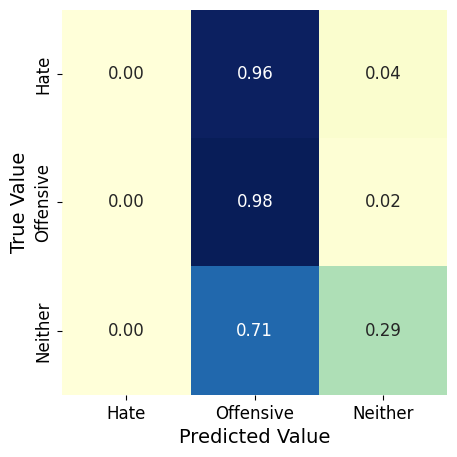

In [ ]:
#Confusion Matrix for TFIDF with additional features
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = panda.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)